# Analyzing the MSTIS simulation

Included in this notebook:

* Opening files for analysis
* Rates, fluxes, total crossing probabilities, and condition transition probabilities
* Per-ensemble properties such as path length distributions and interface crossing probabilities
* Move scheme analysis
* Replica exchange analysis
* Replica move history tree visualization
* Replaying the simulation
* MORE TO COME! Like free energy projections, path density plots, and more

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

The optimum way to use storage depends on whether you're doing production or analysis. For analysis, you should open the file as an `AnalysisStorage` object. This makes the analysis much faster.

In [2]:
storage = paths.AnalysisStorage("mstis.nc")

In [3]:
mstis = storage.networks.load(0)

## Reaction rates

TIS methods are especially good at determining reaction rates, and OPS makes it extremely easy to obtain the rate from a TIS network.

Note that, although you can get the rate directly, it is very important to look at other results of the sampling (illustrated in this notebook and in notebooks referred to herein) in order to check the validity of the rates you obtain.

By default, the built-in analysis calculates histograms the maximum value of some order parameter and the pathlength of every sampled ensemble. You can add other things to this list as well, but you must always specify histogram parameters for these two. The pathlength is in units of frames.

In [4]:
mstis.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
mstis.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }

In [5]:
%%time
mstis.rate_matrix(storage)

CPU times: user 29.4 s, sys: 147 ms, total: 29.6 s
Wall time: 30.8 s


,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,5.75069e-05,7.94774e-05
"{x|opB(x) in [0.0, 0.04]}",0.000221333,NaN,0.000268272
"{x|opC(x) in [0.0, 0.04]}",0.000190053,6.83186e-05,NaN


The self-rates (the rate of returning the to initial state) are undefined, and return not-a-number.

The rate is calcuated according to the formula:

$$k_{AB} = \phi_{A,0} P(B|\lambda_m) \prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$$

where $\phi_{A,0}$ is the flux from state A through its innermost interface, $P(B|\lambda_m)$ is the conditional transition probability (the probability that a path which crosses the interface at $\lambda_m$ ends in state B), and $\prod_{i=0}^{m-1} P(\lambda_{i+1} | \lambda_i)$ is the total crossing probability. We can look at each of these terms individually.

### Total crossing probability

In [6]:
stateA = storage.volumes["A"]
stateB = storage.volumes["B"]
stateC = storage.volumes["C"]

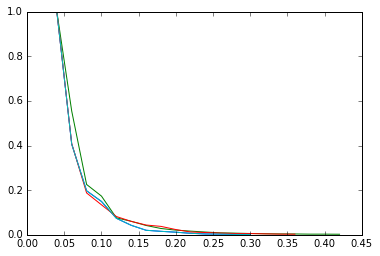

In [7]:
tcp_AB = mstis.transitions[(stateA, stateB)].tcp
tcp_AC = mstis.transitions[(stateA, stateC)].tcp
tcp_BC = mstis.transitions[(stateB, stateC)].tcp
tcp_BA = mstis.transitions[(stateB, stateA)].tcp
tcp_CA = mstis.transitions[(stateC, stateA)].tcp
tcp_CB = mstis.transitions[(stateC, stateB)].tcp

plt.plot(tcp_AB.x, tcp_AB)
plt.plot(tcp_CA.x, tcp_CA)
plt.plot(tcp_BC.x, tcp_BC)
plt.plot(tcp_AC.x, tcp_AC) # same as tcp_AB in MSTIS

We normally look at these on a log scale:

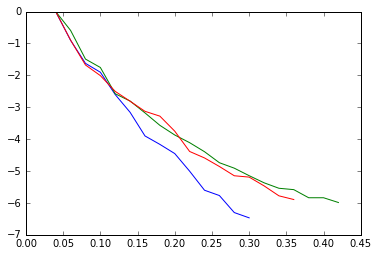

In [8]:
plt.plot(tcp_AB.x, np.log(tcp_AB))
plt.plot(tcp_CA.x, np.log(tcp_CA))
plt.plot(tcp_BC.x, np.log(tcp_BC))

### Flux

Here we also calculate the flux contribution to each transition. The flux is calculated based on 

In [9]:
import pandas as pd
flux_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    flux_matrix.set_value(state_pair[0], state_pair[1], transition._flux)

flux_matrix

,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,0.0227892,0.0227892
"{x|opB(x) in [0.0, 0.04]}",0.0192496,NaN,0.0192496
"{x|opC(x) in [0.0, 0.04]}",0.0217421,0.0217421,NaN


### Conditional transition probability

In [10]:
outer_ctp_matrix = pd.DataFrame(columns=mstis.states, index=mstis.states)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    outer_ctp_matrix.set_value(state_pair[0], state_pair[1], transition.ctp[transition.ensembles[-1]])    

outer_ctp_matrix

,"{x|opA(x) in [0.0, 0.04]}","{x|opB(x) in [0.0, 0.04]}","{x|opC(x) in [0.0, 0.04]}"
"{x|opA(x) in [0.0, 0.04]}",NaN,0.124641,0.17226
"{x|opB(x) in [0.0, 0.04]}",0.26235,NaN,0.317988
"{x|opC(x) in [0.0, 0.04]}",0.209583,0.0753391,NaN


In [11]:
ctp_by_interface = pd.DataFrame(index=mstis.transitions)
for state_pair in mstis.transitions:
    transition = mstis.transitions[state_pair]
    for ensemble_i in range(len(transition.ensembles)):
        ctp_by_interface.set_value(
            state_pair, ensemble_i,
            transition.conditional_transition_probability(
                storage,
                transition.ensembles[ensemble_i]
        ))
    
    
ctp_by_interface  

,0,1,2
"({x|opC(x) in [0.0, 0.04]}, {x|opB(x) in [0.0, 0.04]})",0.000891,0.009009,0.075339
"({x|opB(x) in [0.0, 0.04]}, {x|opA(x) in [0.0, 0.04]})",0.000891,0.104742,0.262350
"({x|opC(x) in [0.0, 0.04]}, {x|opA(x) in [0.0, 0.04]})",0.022968,0.068508,0.209583
"({x|opB(x) in [0.0, 0.04]}, {x|opC(x) in [0.0, 0.04]})",0.028512,0.094149,0.317988
"({x|opA(x) in [0.0, 0.04]}, {x|opC(x) in [0.0, 0.04]})",0.018909,0.026928,0.172260
"({x|opA(x) in [0.0, 0.04]}, {x|opB(x) in [0.0, 0.04]})",0.000000,0.010989,0.124641


## Path ensemble properties

In [12]:
hists_A = mstis.transitions[(stateA, stateB)].histograms
hists_B = mstis.transitions[(stateB, stateC)].histograms
hists_C = mstis.transitions[(stateC, stateB)].histograms

### Interface crossing probabilities

We obtain the total crossing probability, shown above, by combining the individual crossing probabilities of 

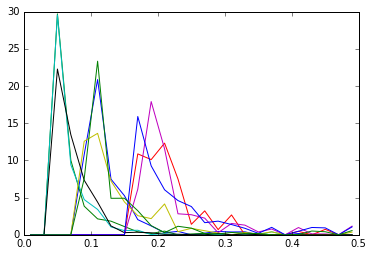

In [13]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        normalized = hist['max_lambda'][ens].normalized()
        plt.plot(normalized.x, normalized)

In [14]:
# add visualization of the sum

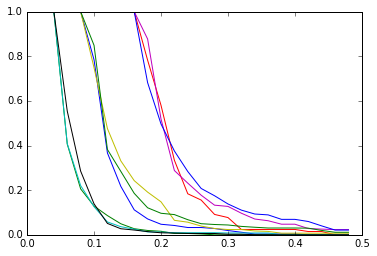

In [15]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, reverse_cumulative)

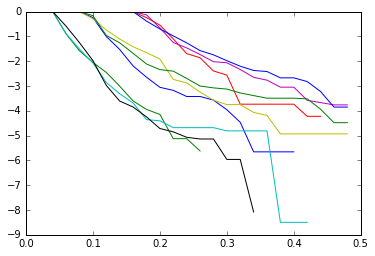

In [16]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['max_lambda']:
        reverse_cumulative = hist['max_lambda'][ens].reverse_cumulative()
        plt.plot(reverse_cumulative.x, np.log(reverse_cumulative))

### Path length histograms

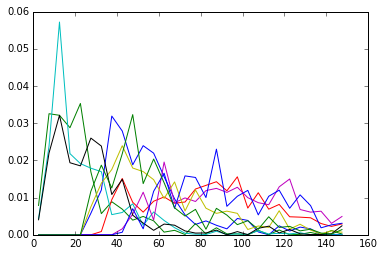

In [17]:
for hist in [hists_A, hists_B, hists_C]:
    for ens in hist['pathlength']:
        normalized = hist['pathlength'][ens].normalized()
        plt.plot(normalized.x, normalized)

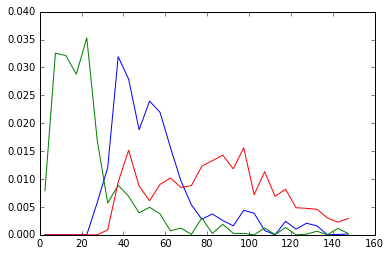

In [18]:
for ens in hists_A['pathlength']:
    normalized = hists_A['pathlength'][ens].normalized()
    plt.plot(normalized.x, normalized)

## Sampling properties

The properties we illustrated above were properties of the path ensembles. If your path ensembles are sufficiently well-sampled, these will never depend on how you sample them.

But to figure out whether you've done a good job of sampling, you often want to look at properties related to the sampling process. OPS also makes these very easy.

### Move scheme analysis

In [19]:
scheme = storage.schemes[0]

In [20]:
scheme.move_summary(storage)

ms_outer_shooting ran 4.792% (expected 4.98%) of the cycles with acceptance 335/484 (69.21%)
repex ran 22.532% (expected 22.39%) of the cycles with acceptance 449/2276 (19.73%)
shooting ran 44.085% (expected 44.78%) of the cycles with acceptance 3271/4453 (73.46%)
minus ran 3.020% (expected 2.99%) of the cycles with acceptance 291/305 (95.41%)
pathreversal ran 25.562% (expected 24.88%) of the cycles with acceptance 2188/2582 (84.74%)


In [21]:
scheme.move_summary(storage, 'shooting')

OneWayShootingMover Out A 2 ran 5.445% (expected 4.98%) of the cycles with acceptance 345/550 (62.73%)
OneWayShootingMover Out B 0 ran 4.633% (expected 4.98%) of the cycles with acceptance 385/468 (82.26%)
OneWayShootingMover Out C 1 ran 4.752% (expected 4.98%) of the cycles with acceptance 363/480 (75.62%)
OneWayShootingMover Out B 1 ran 5.019% (expected 4.98%) of the cycles with acceptance 361/507 (71.20%)
OneWayShootingMover Out B 2 ran 5.059% (expected 4.98%) of the cycles with acceptance 341/511 (66.73%)
OneWayShootingMover Out C 2 ran 4.851% (expected 4.98%) of the cycles with acceptance 330/490 (67.35%)
OneWayShootingMover Out A 0 ran 4.851% (expected 4.98%) of the cycles with acceptance 403/490 (82.24%)
OneWayShootingMover Out A 1 ran 4.990% (expected 4.98%) of the cycles with acceptance 381/504 (75.60%)
OneWayShootingMover Out C 0 ran 4.485% (expected 4.98%) of the cycles with acceptance 362/453 (79.91%)


In [22]:
scheme.move_summary(storage, 'minus')

Minus ran 0.950% (expected 1.00%) of the cycles with acceptance 92/96 (95.83%)
Minus ran 1.010% (expected 1.00%) of the cycles with acceptance 97/102 (95.10%)
Minus ran 1.059% (expected 1.00%) of the cycles with acceptance 102/107 (95.33%)


In [23]:
scheme.move_summary(storage, 'repex')

ReplicaExchange ran 2.564% (expected 2.49%) of the cycles with acceptance 43/259 (16.60%)
ReplicaExchange ran 2.445% (expected 2.49%) of the cycles with acceptance 33/247 (13.36%)
ReplicaExchange ran 2.495% (expected 2.49%) of the cycles with acceptance 97/252 (38.49%)
ReplicaExchange ran 2.624% (expected 2.49%) of the cycles with acceptance 41/265 (15.47%)
ReplicaExchange ran 2.673% (expected 2.49%) of the cycles with acceptance 44/270 (16.30%)
ReplicaExchange ran 2.287% (expected 2.49%) of the cycles with acceptance 67/231 (29.00%)
ReplicaExchange ran 2.554% (expected 2.49%) of the cycles with acceptance 36/258 (13.95%)
ReplicaExchange ran 2.564% (expected 2.49%) of the cycles with acceptance 17/259 (6.56%)
ReplicaExchange ran 2.327% (expected 2.49%) of the cycles with acceptance 71/235 (30.21%)


In [24]:
scheme.move_summary(storage, 'pathreversal')

PathReversal ran 2.574% (expected 2.49%) of the cycles with acceptance 251/260 (96.54%)
PathReversal ran 2.643% (expected 2.49%) of the cycles with acceptance 267/267 (100.00%)
PathReversal ran 2.386% (expected 2.49%) of the cycles with acceptance 164/241 (68.05%)
PathReversal ran 2.465% (expected 2.49%) of the cycles with acceptance 245/249 (98.39%)
PathReversal ran 2.564% (expected 2.49%) of the cycles with acceptance 255/259 (98.46%)
PathReversal ran 2.614% (expected 2.49%) of the cycles with acceptance 108/264 (40.91%)
PathReversal ran 2.703% (expected 2.49%) of the cycles with acceptance 258/273 (94.51%)
PathReversal ran 2.495% (expected 2.49%) of the cycles with acceptance 204/252 (80.95%)
PathReversal ran 2.683% (expected 2.49%) of the cycles with acceptance 266/271 (98.15%)
PathReversal ran 2.435% (expected 2.49%) of the cycles with acceptance 170/246 (69.11%)


### Replica exchange sampling

See the notebook `repex_networks.ipynb` for more details on tools to study the convergence of replica exchange. However, a few simple examples are shown here. All of these are analyzed with a separate object, `ReplicaNetwork`.

In [25]:
repx_net = paths.ReplicaNetwork(storage=storage)

#### Replica exchange mixing matrix

In [26]:
repx_net.mixing_matrix()

,-3,-2,1,2,7,3,6,5,9,0,8,4,-1
-3,0.00000,0.000000,0.039520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-2,0.00000,0.000000,0.000000,0.035645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.03952,0.000000,0.000000,0.000000,0.017048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.035645,0.000000,0.000000,0.000000,0.013948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00000,0.000000,0.017048,0.000000,0.000000,0.000000,0.037582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00000,0.000000,0.000000,0.013948,0.000000,0.000000,0.000000,0.015885,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00000,0.000000,0.000000,0.000000,0.037582,0.000000,0.000000,0.000000,0.012786,0.000000,0.000000,0.000000,0.000000
5,0.00000,0.000000,0.000000,0.000000,0.000000,0.015885,0.000000,0.000000,0.006587,0.000000,0.000000,0.000000,0.000000
9,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012786,0.006587,0.000000,0.025959,0.000000,0.000000,0.000000
0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025959,0.000000,0.027509,0.000000,0.000000


#### Replica exchange graph

The mixing matrix tells a story of how well various interfaces are connected to other interfaces. The replica exchange graph is essentially a visualization of the mixing matrix (actually, of the transition matrix -- the mixing matrix is a symmetrized version of the transition matrix).

Note: We're still developing better layout tools to visualize these.

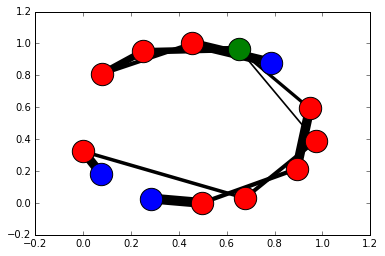

In [27]:
repxG = paths.ReplicaNetworkGraph(repx_net)
repxG.draw('spring')

#### Replica exchange flow

Replica flow is defined as ***TODO***

Flow is designed for calculations where the replica exchange graph is linear, which ours clearly is not. However, we can define the flow over a subset of the interfaces.

### Replica move history tree

In [28]:
import openpathsampling.visualize as visualizations
reload(visualizations)
from IPython.display import SVG

history = visualizations.ReplicaHistoryTree(
    storage=storage,
    steps=storage.steps[0:200],
    replica=1
)

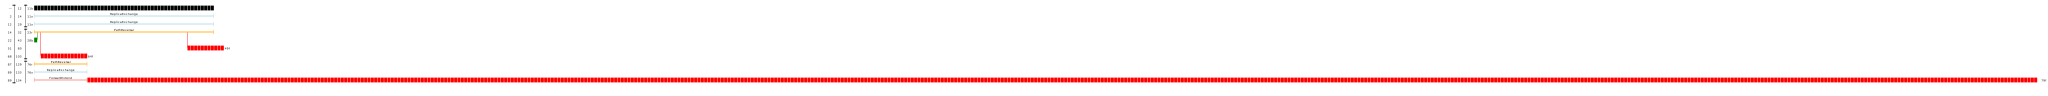

In [29]:
history.view.zoom = 1.0
history.view.scale_y = 24
history.view.scale_x = 10
history.view.font_size = 0.35
history.view.horizontal_gap = 0.05

SVG(history.view.to_svg())

In [30]:
decorrelated = history.decorrelated_trajectories
print "We have " + str(len(decorrelated)) + " decorrelated trajectories."

We have 3 decorrelated trajectories.


### Visualizing trajectories

In [31]:
from toy_plot_helpers import ToyPlot
background = ToyPlot()
background.contour_range = np.arange(-1.5, 1.0, 0.1)
background.add_pes(storage.engines[0].pes)

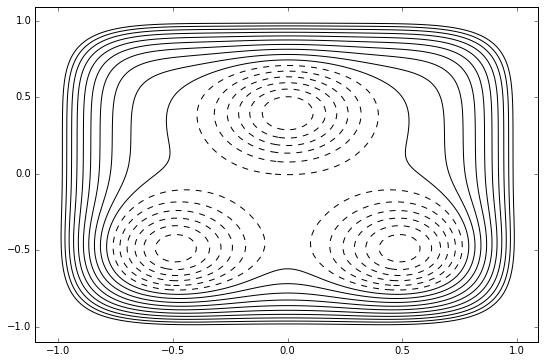

In [32]:
xval = paths.CV_Function("xval", lambda snap : snap.xyz[0][0])
yval = paths.CV_Function("yval", lambda snap : snap.xyz[0][1])
vis = paths.LiveVisualization(mstis, xval, yval, [-1.0, 1.0], [-1.0, 1.0])
vis.background = background.plot()

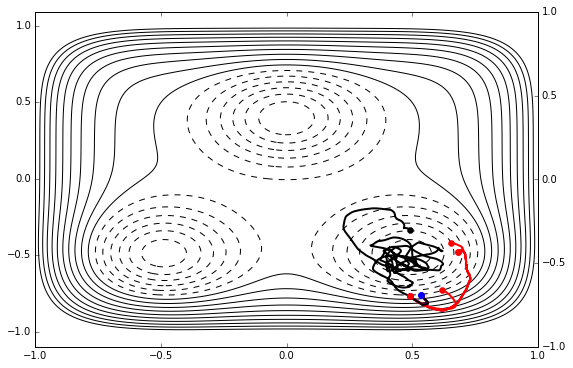

In [33]:
vis.draw_samples(history.trial_samples)

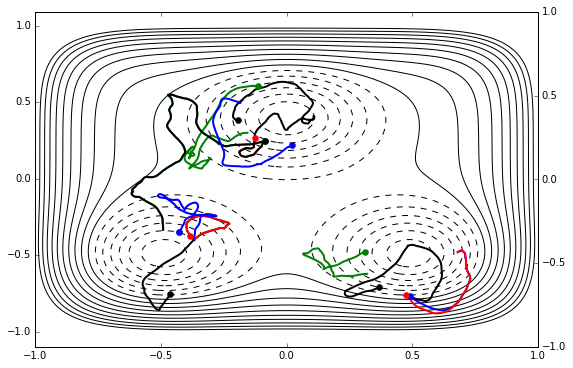

In [34]:
#! skip
# The skip directive tells our test runner not to run this cell
import time
max_step = 10
for step in storage.steps[0:max_step]:
    vis.draw_ipynb(step)
    time.sleep(0.1)

## Histogramming data (TODO)